<a href="https://colab.research.google.com/github/ML4SCI/DeepLearnHackathon/blob/main/GravitationalLensingChallenge/StrongLensingChallenge-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task A: Multi-Class Classification

Gravitational lensing has been a cornerstone in many cosmology experiments and studies since it was discussed in Einstein’s calculations back in 1936 and discovered in 1979, and one area of particular interest is the study of dark matter via substructure in strong lensing images. In this challenge, we focus on exploring the potential of supervised models in identifying dark matter based on simulated strong lensing images with different substructure.

This is an example notebook for the Multi-Class Classification Challenge. In this notebook, we demonstrate a simple CNN model implemented using the PyTorch library to solve the task of multi-class classification of strong lensing images.

### Dataset

The Dataset consists of three classes, strong lensing images with no substructure, CDM (cold dark matter) substructure, and axion substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.

Link to the Dataset: https://drive.google.com/file/d/1AZAJzJdm6FJT4rIyY9N_6FcKLf8VZtn8/view?usp=sharing

### Evaluation Metrics

* ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)   
* Accuracy, Precision, Recall, and F1 Score

The model performance will be tested on the hidden test dataset based on the above metrics. More details about these metrics and the code to calculate them has been shared below.

### Instructions for using the notebook

1. Use GPU acceleration: (Edit --> Notebook settings --> Hardware accelerator --> GPU)
2. Run the cells: (Runtime --> Run all)

In [1]:
!pip install gdown

In [2]:
import gdown

In [3]:
import os
# Check if the dataset folder is missing
if not os.path.exists('./dataset'):
    # Download and extract the dataset
    !gdown "http://drive.google.com/uc?id=1AZAJzJdm6FJT4rIyY9N_6FcKLf8VZtn8"
    !unzip -q dataset.zip

Downloading...
From (original): http://drive.google.com/uc?id=1AZAJzJdm6FJT4rIyY9N_6FcKLf8VZtn8
From (redirected): https://drive.google.com/uc?id=1AZAJzJdm6FJT4rIyY9N_6FcKLf8VZtn8&confirm=t&uuid=f51b0238-3af9-4ef2-93cb-3e79bc455fdc
To: /content/dataset.zip
100% 1.19G/1.19G [00:12<00:00, 92.9MB/s]


## Multi-Class Classification using a Supervised Model

### 1. Data Visualization and Preprocessing

#### 1.1 Import all the necessary libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
from numpy import interp
from itertools import cycle
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
%matplotlib inline

#### 1.2 Preview the Data

Samples with no substructure: 


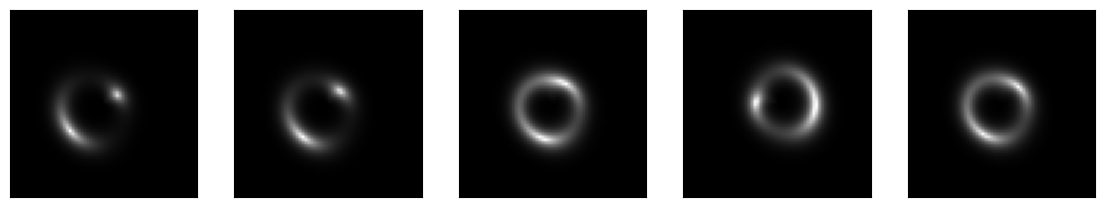

Samples with spherical substructure: 


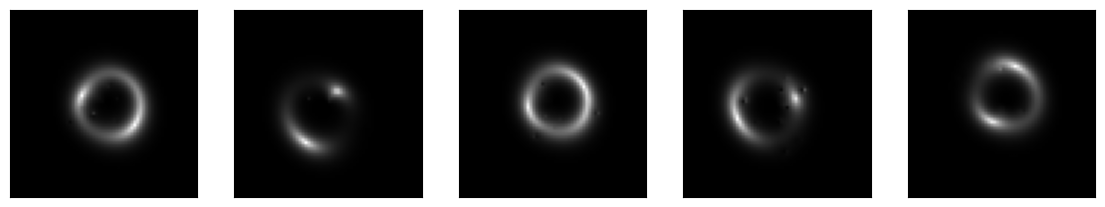

Samples with vortex substructure: 


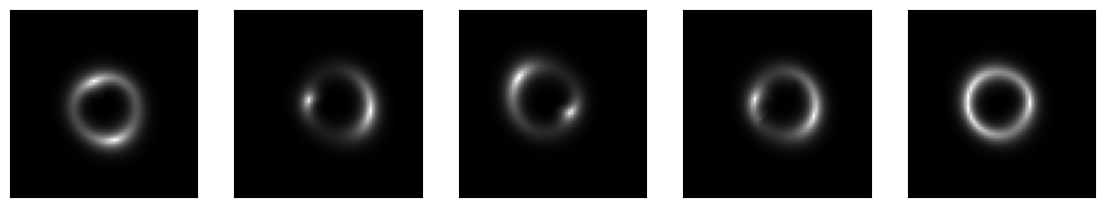

In [5]:
# Define the input paths
train_path1 = './dataset/train/no'
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".npy")]
train_path2 = './dataset/train/cdm'
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".npy")]
train_path3 = './dataset/train/axion'
train_files3 = [os.path.join(train_path3, f) for f in os.listdir(train_path3) if f.endswith(".npy")]

# Number of samples to display per class
n = 5

# Plot the samples with no substructure
i = 1
print('Samples with no substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]  # Set the figure size
for image in train_files1[:n]:
    ax = plt.subplot(3, n, i)  # Create subplot
    plt.imshow(np.load(image).reshape(64, 64), cmap='gray')  # Load and display the image
    ax.get_xaxis().set_visible(False)  # Hide x-axis
    ax.get_yaxis().set_visible(False)  # Hide y-axis
    i += 1
plt.show()  # Show the plot

# Plot the samples with spherical substructure
print('Samples with spherical substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]  # Set the figure size
for image in train_files2[:n]:
    ax = plt.subplot(3, n, i)  # Create subplot
    plt.imshow(np.load(image).reshape(64, 64), cmap='gray')  # Load and display the image
    ax.get_xaxis().set_visible(False)  # Hide x-axis
    ax.get_yaxis().set_visible(False)  # Hide y-axis
    i += 1
plt.show()  # Show the plot

# Plot the samples with vortex substructure
print('Samples with vortex substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]  # Set the figure size
for image in train_files3[:n]:
    ax = plt.subplot(3, n, i)  # Create subplot
    plt.imshow(np.load(image).reshape(64, 64), cmap='gray')  # Load and display the image
    ax.get_xaxis().set_visible(False)  # Hide x-axis
    ax.get_yaxis().set_visible(False)  # Hide y-axis
    i += 1

#### 1.3 Import Training and Validation Data

In [6]:
# Set Batch Size
batch_size = 100

# Define a function to load .npy files
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))  # Load the numpy file and convert it to a torch tensor
    return sample

# Load training data
train_data = torchvision.datasets.DatasetFolder(root='./dataset/train', loader=npy_loader, extensions='.npy')
print("Training Classes: " + str(train_data.class_to_idx))  # Print the classes found in the training data
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)  # Create a data loader for training data

# Load validation data
val_data = torchvision.datasets.DatasetFolder(root='./dataset/val', loader=npy_loader, extensions='.npy')
print("Validation Classes: " + str(val_data.class_to_idx))  # Print the classes found in the validation data
val_data_loader = data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)  # Create a data loader for validation data

Training Classes: {'axion': 0, 'cdm': 1, 'no': 2}
Validation Classes: {'axion': 0, 'cdm': 1, 'no': 2}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 2. Training

#### 2.1 Defining a CNN Model

You may refer to this [article](https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148) to learn about Convolutional Neural Networks (CNN)

In [7]:
# Define the Convolutional Neural Network (CNN) class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=0)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=0)

        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1, padding=0)

        # Define the first fully connected (linear) layer
        self.linear1 = nn.Linear(120, 64)

        # Define the second fully connected (linear) layer
        self.linear2 = nn.Linear(64, 3)

        # Define the activation function
        self.tanh = nn.Tanh()

        # Define the average pooling layer
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Apply the first convolutional layer
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.avgpool(x)

        # Apply the second convolutional layer
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.avgpool(x)

        # Apply the third convolutional layer
        x = self.conv3(x)
        x = self.tanh(x)

        # Flatten the tensor for the fully connected layers
        x = x.reshape(x.shape[0], -1)

        # Apply the first fully connected layer
        x = self.linear1(x)
        x = self.tanh(x)

        # Apply the second fully connected layer
        x = self.linear2(x)

        return x

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the CNN model and move it to the appropriate device
model = CNN().to(device)

#### 2.2 Training the CNN Model

In [8]:
# Loss Function
criteria = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Calculate the number of batches for training data
n_batches_train = (len(train_files1) * 3) / batch_size  # Equal number of files in each class

# Set the number of training epochs
n_epochs = 20
loss_array = []  # To store the loss values

# Progress bar for epochs
pbar = tqdm(range(1, n_epochs + 1))
for epoch in pbar:
    train_loss = 0.0
    train_acc = 0.0

    # Iterate over the training data loader
    for step, (x_tr, y_tr) in enumerate(train_data_loader):
        data = x_tr.to(device).float()  # Move input data to the device and convert to float
        labels = y_tr.to(device, dtype=torch.long)  # Move labels to the device and convert to long
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(data)  # Forward pass through the model
        _, preds = torch.max(outputs.data, 1)  # Get the predictions
        correct = (preds == labels).float().sum()  # Calculate the number of correct predictions
        loss = criteria(outputs, labels)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

        train_loss += loss.item()  # Accumulate the loss
        train_acc += correct.item() / data.shape[0]  # Accumulate the accuracy

    # Calculate the average loss and accuracy for the epoch
    train_loss = train_loss / n_batches_train
    train_acc = train_acc / n_batches_train

    # Display the training statistics
    pbar.set_postfix({'Training Loss': train_loss, 'Training Acc': train_acc})

  0%|          | 0/20 [00:00<?, ?it/s]

### 3. Testing

#### 3.1 Testing the CNN Model on Validation Data

In [9]:
# Initialize lists to store scores and labels
y_score = []
y_test = []

# Iterate over the validation data loader
for _, (x_ts, y_ts) in enumerate(val_data_loader):
    mini_val_data = x_ts.to(device).float()  # Move validation data to the device and convert to float
    y_ts = y_ts.to(device, dtype=torch.long)  # Move labels to the device and convert to long

    with torch.no_grad():  # Disable gradient calculation for validation
        outputs = model(mini_val_data)  # Forward pass through the model
        probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Apply softmax to get probabilities

    # Append the probabilities and labels to the respective lists
    y_score.append(probabilities.cpu().detach().numpy())
    y_test.append(y_ts.cpu().detach().numpy())

# Convert the lists to numpy arrays and reshape them
y_score = np.asarray(y_score).reshape(-1, 3)
y_val = np.asarray(y_test).reshape(-1)

# Binarize the labels for multi-class evaluation
y_val = label_binarize(y_val, classes=[0, 1, 2])

#### 3.2 Plotting the ROC Curve

You may refer to this [article](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) to learn about the ROC Curve

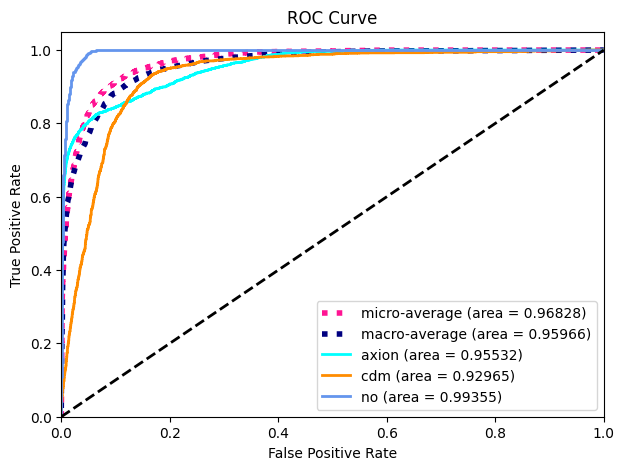

In [10]:
# Number of classes
n_classes = y_val.shape[1]

# Initialize dictionaries to store false positive rates (fpr), true positive rates (tpr), and ROC AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Initialize mean true positive rate (tpr)
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average it and compute macro-average ROC curve and ROC area
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting the ROC curves
plt.rcParams['figure.figsize'] = [7, 5]  # Set figure size
lw = 2  # Line width
plt.figure()

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"], 5)),
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"], 5)),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curves for each class
labels = ['axion', 'cdm', 'no']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i], 5)))

# Plot the diagonal line (chance level)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={"size": 10})  # Add legend
plt.show()  # Display the plot

#### 3.3 Calculate evaluation metrics

You may refer to this [article](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9) to learn more about these metrics

In [11]:
# Convert the predicted probabilities to class labels
y_pred = np.argmax(y_score, axis=1)

# Convert y_val from one-hot encoding to class labels
y_true = np.argmax(y_val, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision}')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f'Recall: {recall}')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

Accuracy: 0.8669333333333333
Precision: 0.8668178443723771
Recall: 0.8669333333333333
F1 Score: 0.8660755140017946


## Submission Guidelines

* Fill out the pre- and post- hackathon surveys.
* You are required to submit a Google Colab Jupyter Notebook (.ipynb and pdf) clearly showing your implementation along with the evaluation metrics (ROC curve, AUC score, and other metrics) for the validation data.
* You must also submit the final trained model, including the model architecture and the trained weights ( For example: HDF5 file, .pb file, .pt file, etc. )
* You can use this example notebook as a template for your work.

> **_NOTE:_**  You are free to use any ML framework such as PyTorch, Keras, TensorFlow, etc.